In [1]:
# %pip install scipy

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from tqdm import tqdm

# import healpy as hp
from scipy.spatial import ConvexHull

import lsst.daf.butler as dafButler

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, SqrtStretch, ImageNormalize, ManualInterval, AsinhStretch, MinMaxInterval, LogStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# Load collection
# repo = 'embargo'
# instrument = "LSSTComCam"
# collection = 'LSSTComCam/runs/DRP/DP1-RC1/w_2025_02/DM-48371'
# butler= dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1-RC1/w_2025_02/DM-48371', instrument=instrument)

repo = '/repo/main'
instrument = "LSSTComCam"
butler= dafButler.Butler(repo, collections='LSSTComCam/runs/DRP/DP1/w_2025_03/DM-48478', instrument=instrument)

# older collections
repo_old = "embargo_new"

butler_50 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241211/w_2024_50/DM-48128", instrument=instrument)
butler_49 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988", instrument=instrument)
butler_48 = dafButler.Butler(repo_old, collections="LSSTComCam/runs/DRP/20241101_20241127/w_2024_48/DM-47841", instrument=instrument)


INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [3]:
bands = ["u", "g", "r", "i", "z", "y"]
verbose = False

for band in bands:
    datasetRefs_dia = butler.query_datasets("goodSeeingDiff_differenceExp", where=f"band='{band}'")

    if verbose:
        print(f"\nDataset references for band '{band}':")
        for dr in datasetRefs_dia:
            print(dr)

    print(f"Found {len(datasetRefs_dia)} differenceExps for band '{band}'")

Found 1003 differenceExps for band 'u'
Found 4179 differenceExps for band 'g'
Found 5094 differenceExps for band 'r'
Found 2875 differenceExps for band 'i'
Found 2690 differenceExps for band 'z'
Found 583 differenceExps for band 'y'


In [4]:
lc_refs = butler.query_datasets("diaSourceTable_tract")
obj_refs = butler.query_datasets("diaObjectTable_tract")
obj_refs_50 = butler_50.query_datasets("diaObjectTable_tract")
obj_refs_49 = butler_49.query_datasets("diaObjectTable_tract")
obj_refs_48 = butler_48.query_datasets("diaObjectTable_tract")


print(f"Number of tracts in diaSourceTable (current): {len(lc_refs)}")
print(f"Number of tracts in diaObjectTable_tract (current): {len(obj_refs)}")
print(f"Number of tracts in diaObjectTable_tract (weekly 50): {len(obj_refs_50)}")
print(f"Number of tracts in diaObjectTable_tract (weekly 49): {len(obj_refs_49)}")
print(f"Number of tracts in diaObjectTable_tract (weekly 48): {len(obj_refs_48)}")

Number of tracts in diaSourceTable (current): 28
Number of tracts in diaObjectTable_tract (current): 28
Number of tracts in diaObjectTable_tract (weekly 50): 40
Number of tracts in diaObjectTable_tract (weekly 49): 45
Number of tracts in diaObjectTable_tract (weekly 48): 43


In [5]:

obj_refs = butler.query_datasets("diaObjectTable_tract")
obj_ref= obj_refs[0]
butler.getURI('diaSourceTable_tract', dataId=obj_ref.dataId)

ResourcePath("file:///sdf/group/rubin/repo/main/LSSTComCam/runs/DRP/DP1/w_2025_03/DM-48478/20250119T135723Z/diaSourceTable_tract/2393/diaSourceTable_tract_2393_lsst_cells_v1_LSSTComCam_runs_DRP_DP1_w_2025_03_DM-48478_20250119T135723Z.parq")

Text(0.5, 1.0, 'Log Number of diaObjects per Number of Sources per Object')

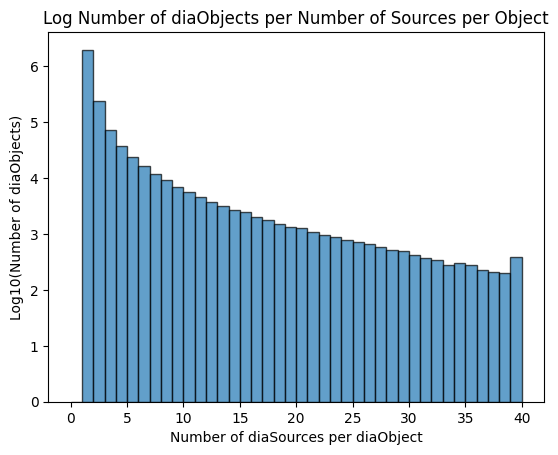

In [6]:
# List of tract indices to process
tract_indices = np.arange(0, len(obj_refs))

# Initialize lists to hold diaObj and diaSource DataFrames
dia_Obj_list = []
diaSource_list = []

# Loop through the specified tracts and fetch the data
for idx in tract_indices:
    obj_ref = obj_refs[idx]  # Select the corresponding obj_ref
    diaObject_tract = butler.get(obj_ref)  # Fetch diaObj for this tract
    diaSource_tract = butler.get('diaSourceTable_tract', dataId=obj_ref.dataId)  # Fetch diaSource for this tract
    
    # Append the results to the lists
    dia_Obj_list.append(diaObject_tract)
    diaSource_list.append(diaSource_tract)

# Concatenate all diaObj and diaSource DataFrames
combined_dia_Obj = pd.concat(dia_Obj_list, ignore_index=False)
combined_diaSource = pd.concat(diaSource_list, ignore_index=False)

# Drop duplicates based on the 'ra' column, keeping the first occurrence
combined_dia_Obj = combined_dia_Obj.drop_duplicates(subset='ra', keep='first')
# Drop duplicates based on the 'ra' column, keeping the first occurrence
combined_diaSource = combined_diaSource.drop_duplicates(subset='ra', keep='first')

diaObject = combined_dia_Obj.copy()
diaSource = combined_diaSource.copy()

# Compute the histogram of nDiaSources
counts, bin_edges = np.histogram(combined_dia_Obj['nDiaSources'], bins=40, range=(0, 40))

# Take the logarithm (base 10) of the counts
log_counts = np.log10(counts + 1)  # Add 1 to avoid log(0)

# Plot the histogram
plt.bar(bin_edges[:-1], log_counts, width=np.diff(bin_edges), align='edge', edgecolor='black', alpha=0.7)
plt.xlabel('Number of diaSources per diaObject')
plt.ylabel('Log10(Number of diaObjects)')
plt.title('Log Number of diaObjects per Number of Sources per Object')

In [7]:
# Array of search radii in degrees
search_radii = np.array([1, 3, 5, 7, 9, 11]) / 3600  # Convert arcseconds to degrees

# Prepare results storage
results_list = []

# Iterate over each row in dia_Obj
for index, target_row in tqdm(diaObject.iloc[:100].iterrows()):
    # Target RA and Dec
    ra_target = target_row['ra']
    dec_target = target_row['dec']
    diaObjectId = index

    # Compute differences in RA and Dec
    delta_ra = diaObject['ra'].values - ra_target
    delta_dec = diaObject['dec'].values - dec_target

    # Scale RA difference by cos(dec_target) to account for spherical projection
    delta_ra_scaled = delta_ra * np.cos(np.radians(dec_target))

    # Compute Euclidean distance
    distance = np.sqrt(delta_ra_scaled**2 + delta_dec**2)

    # Count matches within each radius and store results
    for radius in search_radii:
        within_radius_count = np.sum(distance <= radius)
        results_list.append({
            'diaObjectId': diaObjectId,
            'radius_arcsec': radius * 3600,  # Convert radius back to arcseconds
            'matches': within_radius_count
        })

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results_list)


6it [00:00, 51.86it/s]

100it [00:01, 55.45it/s]


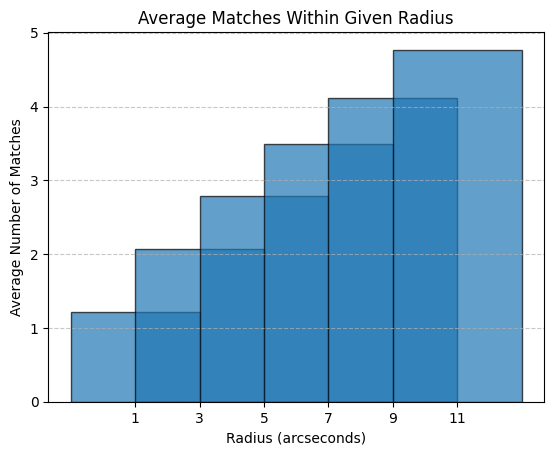

In [8]:
# Group by radius_arcsec and calculate the average matches
average_matches = results_df.groupby('radius_arcsec')['matches'].mean()

# Plot the histogram
plt.bar(average_matches.index, average_matches.values, width=4, edgecolor='black', alpha=0.7)
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Average Number of Matches')
plt.title('Average Matches Within Given Radius')
plt.xticks(average_matches.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [9]:
# Define the central coordinates and selection radius for each field
fields = {
    "ECDFS": (53.13, -28.10),  # Extended Chandra Deep Field South
    "EDFS": (59.10, -48.73),  # Euclid Deep Field South
    "Rubin_SV_38_7": (37.86, 6.98),  # Low Ecliptic Latitude Field
    "Rubin_SV_95_-25": (95.00, -25.00),  # Low Galactic Latitude Field
    "47_Tuc": (6.02, -72.08),  # 47 Tuc Globular Cluster
    "Fornax_dSph": (40.00, -34.45)  # Fornax Dwarf Spheroidal Galaxy
}

# Define a radius (in degrees) for selecting sources near each field
selection_radius = 2.0  # 2-degree radius around each field center

# Create new DataFrames for each field
ECDFS_df = diaObject[(np.abs(diaObject['ra'] - fields['ECDFS'][0]) < selection_radius) &
                        (np.abs(diaObject['dec'] - fields['ECDFS'][1]) < selection_radius)]

EDFS_df = diaObject[(np.abs(diaObject['ra'] - fields['EDFS'][0]) < selection_radius) &
                       (np.abs(diaObject['dec'] - fields['EDFS'][1]) < selection_radius)]

Rubin_SV_38_7_df = diaObject[(np.abs(diaObject['ra'] - fields['Rubin_SV_38_7'][0]) < selection_radius) &
                                (np.abs(diaObject['dec'] - fields['Rubin_SV_38_7'][1]) < selection_radius)]

Rubin_SV_95_minus25_df = diaObject[(np.abs(diaObject['ra'] - fields['Rubin_SV_95_-25'][0]) < selection_radius) &
                                      (np.abs(diaObject['dec'] - fields['Rubin_SV_95_-25'][1]) < selection_radius)]

Tuc_47_df = diaObject[(np.abs(diaObject['ra'] - fields['47_Tuc'][0]) < selection_radius) &
                         (np.abs(diaObject['dec'] - fields['47_Tuc'][1]) < selection_radius)]

Fornax_dSph_df = diaObject[(np.abs(diaObject['ra'] - fields['Fornax_dSph'][0]) < selection_radius) &
                              (np.abs(diaObject['dec'] - fields['Fornax_dSph'][1]) < selection_radius)]

# Print the number of rows in each new DataFrame
print(f"ECDFS: {len(ECDFS_df)} rows")
print(f"EDFS: {len(EDFS_df)} rows")
print(f"Rubin_SV_38_7: {len(Rubin_SV_38_7_df)} rows")
print(f"Rubin_SV_95_-25: {len(Rubin_SV_95_minus25_df)} rows")
print(f"47 Tuc: {len(Tuc_47_df)} rows")
print(f"Fornax dSph: {len(Fornax_dSph_df)} rows")

ECDFS: 700957 rows
EDFS: 359852 rows
Rubin_SV_38_7: 102605 rows
Rubin_SV_95_-25: 613610 rows
47 Tuc: 134564 rows
Fornax dSph: 35174 rows


In [10]:
from tqdm import tqdm

def create_mag(sciFlux):
    """Move flux into magnitudes
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux

    Returns
    -------
    mag  : `float`
        Magnitude
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    
    return mag

# Ensure ECDFS_df is a standalone copy
ECDFS_df = ECDFS_df.copy()

# Step 3: Calculate magnitudes for all bands (vectorized)
for band in tqdm(['i', 'g', 'r', 'y', 'z', 'u']):
    flux_col = f"{band}_scienceFluxMean"
    mag_col = f"{band}_scienceMagMean"
    
    # Assuming create_mag is a function that works element-wise
    ECDFS_df[mag_col] = create_mag(ECDFS_df[flux_col].values)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 153.64it/s]


In [11]:
# Array of search radii in degrees
search_radii = np.array([.5, 1, 2, 3, 4, 5]) / 3600  # Convert arcseconds to degrees
ECDFS_df_g = ECDFS_df[ECDFS_df['g_scienceFluxMean'].notna()]
ECDFS_df_u = ECDFS_df[ECDFS_df['u_scienceFluxMean'].notna()]
ECDFS_df_i = ECDFS_df[ECDFS_df['i_scienceFluxMean'].notna()]
ECDFS_df_r = ECDFS_df[ECDFS_df['r_scienceFluxMean'].notna()]
ECDFS_df_z = ECDFS_df[ECDFS_df['z_scienceFluxMean'].notna()]
ECDFS_df_y = ECDFS_df[ECDFS_df['y_scienceFluxMean'].notna()]
# Prepare results storage
results_list = []

# Iterate over each row in dia_Obj
for index, target_row in tqdm(ECDFS_df_g.iloc[:30000].iterrows()):
    # Target RA and Dec
    ra_target = target_row['ra']
    dec_target = target_row['dec']
    diaObjectId = index

    # Compute differences in RA and Dec
    delta_ra = ECDFS_df_g['ra'].values - ra_target
    delta_dec = ECDFS_df_g['dec'].values - dec_target

    # Scale RA difference by cos(dec_target) to account for spherical projection
    delta_ra_scaled = delta_ra * np.cos(np.radians(dec_target))

    # Compute Euclidean distance
    distance = np.sqrt(delta_ra_scaled**2 + delta_dec**2)

    # Count matches within each radius and store results
    for radius in search_radii:
        within_radius_count = np.sum(distance <= radius)
        results_list.append({
            'diaObjectId': diaObjectId,
            'radius_arcsec': radius * 3600,  # Convert radius back to arcseconds
            'matches': within_radius_count
        })

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results_list)

30000it [00:31, 951.54it/s]


In [12]:
len(ECDFS_df_g)

178756

In [13]:
# Define the magnitude bins (ranges in units of 1 magnitude)
magnitude_bins = range(17, 24)  # Magnitudes from 17 to 23 inclusive

# Initialize an empty DataFrame to store filtered results
filtered_results_df = pd.DataFrame()

# Iterate through each magnitude bin
for mag in magnitude_bins:
    # Select diaObjectId of objects within the current magnitude bin
    dia_object_ids = ECDFS_df_g[
        (ECDFS_df_g['g_scienceMagMean'] >= mag) & 
        (ECDFS_df_g['g_scienceMagMean'] < mag + 1)
    ].index

    # Filter rows in results_df using the selected diaObjectIds
    filtered_rows = results_df[results_df['diaObjectId'].isin(dia_object_ids)].copy()
    
    # Add a new column to indicate the magnitude bin
    filtered_rows['magnitude_bin'] = f"{mag}-{mag + 1}"

    # Append the filtered rows to the result DataFrame
    filtered_results_df = pd.concat([filtered_results_df, filtered_rows])

# Display the filtered results
print(filtered_results_df)

                diaObjectId  radius_arcsec  matches magnitude_bin
108     2227254316106776581            0.5        1         17-18
109     2227254316106776581            1.0        2         17-18
110     2227254316106776581            2.0        2         17-18
111     2227254316106776581            3.0        2         17-18
112     2227254316106776581            4.0        2         17-18
...                     ...            ...      ...           ...
179995  2226757336851041647            1.0        1         23-24
179996  2226757336851041647            2.0        1         23-24
179997  2226757336851041647            3.0        1         23-24
179998  2226757336851041647            4.0        2         23-24
179999  2226757336851041647            5.0        2         23-24

[64734 rows x 4 columns]


In [14]:
res_1718 = filtered_results_df[filtered_results_df['magnitude_bin'] == '17-18']
res_1819 = filtered_results_df[filtered_results_df['magnitude_bin'] == '18-19']
res_1920 = filtered_results_df[filtered_results_df['magnitude_bin'] == '19-20']
res_2021 = filtered_results_df[filtered_results_df['magnitude_bin'] == '20-21']
res_2122 = filtered_results_df[filtered_results_df['magnitude_bin'] == '21-22']
res_2223 = filtered_results_df[filtered_results_df['magnitude_bin'] == '22-23']
res_2324 = filtered_results_df[filtered_results_df['magnitude_bin'] == '23-24']

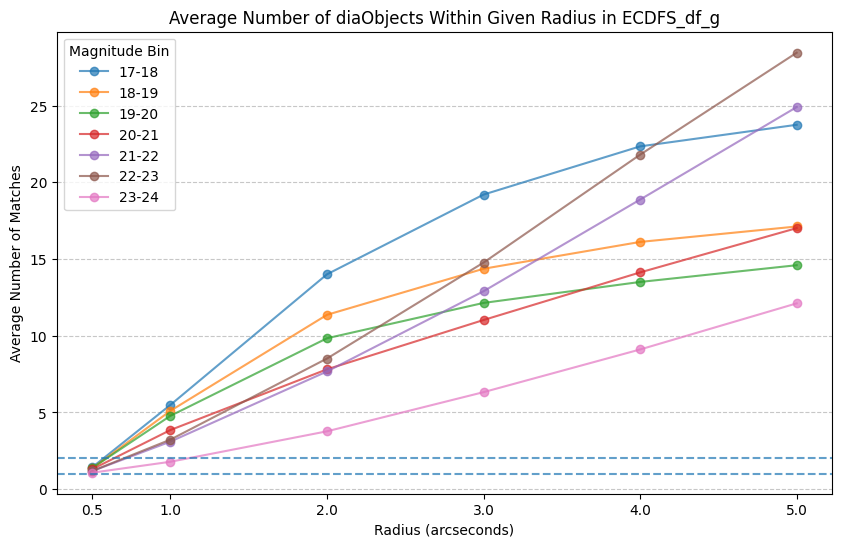

In [15]:
import matplotlib.pyplot as plt

# List of datasets and corresponding labels
datasets = [
    (res_1718, '17-18'),
    (res_1819, '18-19'),
    (res_1920, '19-20'),
    (res_2021, '20-21'),
    (res_2122, '21-22'),
    (res_2223, '22-23'),
    (res_2324, '23-24')
]

# Plot each dataset
plt.figure(figsize=(10, 6))
for subset, label in datasets:
    # Group by radius_arcsec and calculate the average matches
    average_matches = subset.groupby('radius_arcsec')['matches'].mean()
    # Plot the results
    plt.plot(average_matches.index, average_matches.values, marker='o', label=label, alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Radius (arcseconds)')
plt.ylabel('Average Number of Matches')
plt.title('Average Number of diaObjects Within Given Radius in ECDFS_df_g')
plt.legend(title="Magnitude Bin")
plt.xticks(average_matches.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(1, linestyle='--', alpha=0.7)
plt.axhline(2, linestyle='--', alpha=0.7)
plt.show()